In [1]:
import sys
sys.path.append('..') 
import os

import pandas as pd
from datetime import date, timedelta, datetime
from dateutil.relativedelta import relativedelta

## Data Loading

In [2]:
# # Save feature_engineered_df 
# feature_engineered_df.to_csv("data/feature_engineered_df.csv")
# # Load feature_engineered_df 
parse_dates = ["date"]
feature_engineered_df = pd.read_csv('data/feature_engineered_df.csv', index_col=[0], parse_dates=parse_dates)
feature_engineered_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4698 entries, 15 to 5912
Data columns (total 17 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   date                              4698 non-null   datetime64[ns]
 1   province                          4698 non-null   object        
 2   current_month_consumption         4698 non-null   float64       
 3   ARIMA_prediction                  4698 non-null   float64       
 4   last_year_same_month_consumption  4698 non-null   float64       
 5   last_year_total_consumption       4698 non-null   float64       
 6   current_month_share               4698 non-null   float64       
 7   previous_1_month_share            4698 non-null   float64       
 8   previous_2_month_share            4698 non-null   float64       
 9   previous_3_month_share            4698 non-null   float64       
 10  previous_1_month_consumption      4698 non-null

## Data Preperation

In [3]:
model_df = feature_engineered_df.sort_values(by=["date"]).reset_index(drop=True).copy()

In [4]:
from src.model_selection.data_preperation import DataPreperation

# Initialize Data Preperation module
dp = DataPreperation(data=model_df)
# Train-Test split
X_train, y_train, X_test, y_test = dp.ts_train_test_split(index_column1="date" ,index_column2="province", lag=2, n_months=55)
 
print("Maximum date at train is: ", X_train.index.max()," Shape is: ", X_train.shape)
print("Minimum date at train is: ", X_train.index.min()," Shape is: ", X_train.shape)
print("Maximum date at test is: ", X_test.index.max(), " Shape is: ", X_test.shape)
print("Minimum date at test is: ", X_test.index.min(), " Shape is: ", X_test.shape)

Maximum date at train is:  (Timestamp('2021-10-01 00:00:00'), 'ŞIRNAK')  Shape is:  (4455, 14)
Minimum date at train is:  (Timestamp('2017-04-01 00:00:00'), 'ADANA')  Shape is:  (4455, 14)
Maximum date at test is:  (Timestamp('2021-11-01 00:00:00'), 'ŞIRNAK')  Shape is:  (81, 14)
Minimum date at test is:  (Timestamp('2021-11-01 00:00:00'), 'ADANA')  Shape is:  (81, 14)


In [5]:
from dateutil import relativedelta

r = relativedelta.relativedelta(model_df.date.min(), date(2021,10,1))

months_difference = (r.years * 12) + r.months
months_difference

-54

## Model Selection

### Utils

#### Scoring

In [6]:
from typing import Any
import numpy as np
from sklearn.metrics import mean_squared_error 
def rmse(actual_value: Any, prediction: Any):
    return np.sqrt(((actual_value - prediction) ** 2)/2)

def ape(actual_value: Any, prediction: Any):
    return abs(actual_value-prediction)/actual_value*100
     
def prep_scoring_df(X_test: pd.DataFrame, y_test: pd.DataFrame, target_col: str="current_month_consumption", col_list: list=None)-> pd.DataFrame:
    scoring_df = X_test.copy()
    scoring_df["actual_value"] = y_test[target_col]
    scoring_df.reset_index(level="province",inplace=True)
    if not col_list:
        col_list = ["province", "actual_value"]
    scoring_df = scoring_df[col_list]
    return scoring_df

def scoring(scoring_df: pd.DataFrame, predictions: Any, model_name: str="XGB", target_value: str="actual_value")-> pd.DataFrame:
    if scoring_df.empty:
        print("Please run 'prep_scoring_df(X_test=X_test, y_test=y_test)' first in order to create scoring df")
        return
    else: 
        temp_df = scoring_df.copy()
    # Insert predictions
    temp_df[f"{model_name}_prediction"] = predictions
    # Add rmse
    temp_df[f"{model_name}_rmse"] = temp_df.apply(lambda row: rmse(row[target_value], row[f"{model_name}_prediction"]), axis=1)
    # Add percentage difference
    temp_df[f"{model_name}_absolute_percent_error"] = temp_df.apply(lambda row: ape(row[target_value], row[f"{model_name}_prediction"]), axis=1)
    
    print("Number of records greater than 20 percent error:",(temp_df[f"{model_name}_absolute_percent_error"] > 20).sum())
    print("Number of records greater than 15 percent error:",(temp_df[f"{model_name}_absolute_percent_error"] > 15).sum())
    print("Number of records greater than 10 percent error:",(temp_df[f"{model_name}_absolute_percent_error"] > 10).sum())
    print("Number of records greater than 5 percent error:",(temp_df[f"{model_name}_absolute_percent_error"] > 5).sum())
    return temp_df

### XGB

In [7]:
# Initialization parameters
init_params = {
    "objective": "reg:gamma"
}
grid_search_params = {
    'alpha': [0.0025, 0.0075], # Defaults to 0
    'lambda': [0.5,], # Defaults to 1
    'colsample_bytree': [1.0], # Defaults to 1
    'learning_rate': [0.045, 0.064], # Defaults to 0.3
    'max_depth': [6], # Defaults to 6
    'min_child_weight': [3], # Defaults to 1
    'n_estimators': [1250, 1500], 
    'subsample': [0.5], # Defaults to 1
}
# # Use this in real product
# grid_search_params = {
#     'alpha': [0.0025, 0.005, 0.0075], # Defaults to 0
#     'lambda': [0.25, 0.5, 0.75], # Defaults to 1
#     'colsample_bytree': [1.0], # Defaults to 1
#     'learning_rate': [i for i in np.linspace(0.01,0.2, num=10)], # Defaults to 0.3
#     'max_depth': [6,7], # Defaults to 6
#     'min_child_weight': [2, 3, 4, 5], # Defaults to 1
#     'n_estimators': [1000, 1500, 2000], 
#     'subsample': [0.5], # Defaults to 1
# }
fit_params = {}

In [8]:
from src.model_selection.data_preperation import DataPreperation
from src.model_selection.modelling import xgb_simulator
for lag in range(5):
    print("Run for Lag=", lag)
    # Train test split
    dp = DataPreperation(data=model_df)
    X_train, y_train, X_test, y_test = dp.ts_train_test_split(index_column1="date" ,index_column2="province", lag=lag, n_months=55)
    # Initialize Simulator
    xgb = xgb_simulator(init_params=init_params, fit_params=fit_params, 
                        grid_search_params=grid_search_params, save=False)
    # Train the model
    xgb(X_train=X_train, y_train=y_train)
    # Set the best_model and best_parameter
    best_model = xgb.best_model
    best_params = xgb.best_params
    print(f"Best Parameters when lag = {lag}",best_params)
    # print("Best Score is: ",xgb.best_score_)
    # Predict test set
    predictons = best_model.predict(X_test)
    # Log results
    xgb_scoring_df = prep_scoring_df(X_test=X_test, y_test=y_test,)
    xgb_scoring_df = scoring(predictions=predictons, scoring_df=xgb_scoring_df, model_name=f"Lag_{lag}_XGB")    


Run for Lag= 0
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best Parameters when lag = 0 {'alpha': 0.0025, 'colsample_bytree': 1.0, 'lambda': 0.5, 'learning_rate': 0.064, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 1500, 'subsample': 0.5}
Number of records greater than 20 percent error: 3
Number of records greater than 15 percent error: 6
Number of records greater than 10 percent error: 7
Number of records greater than 5 percent error: 19
Run for Lag= 1
Fitting 5 folds for each of 8 candidates, totalling 40 fits


In [ ]:
"""-----------------------------------------------------------------"""
# Run for Lag= 0
# Fitting 5 folds for each of 12 candidates, totalling 60 fits
# Best Parameters when lag = 0 {'alpha': 0.0075, 'colsample_bytree': 1.0, 'lambda': 0.5, 'learning_rate': 0.045, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 1250, 'subsample': 0.5}
# Number of records greater than 20 percent error: 2
# Number of records greater than 15 percent error: 3
# Number of records greater than 10 percent error: 6
# Number of records greater than 5 percent error: 20
# Run for Lag= 1
# Fitting 5 folds for each of 12 candidates, totalling 60 fits
# Best Parameters when lag = 1 {'alpha': 0.005, 'colsample_bytree': 1.0, 'lambda': 0.5, 'learning_rate': 0.045, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 1250, 'subsample': 0.5}
# Number of records greater than 20 percent error: 0
# Number of records greater than 15 percent error: 1
# Number of records greater than 10 percent error: 1
# Number of records greater than 5 percent error: 2
# Fitting 5 folds for each of 6 candidates, totalling 30 fits
# Best Parameters when lag = 2 {'alpha': 0.005, 'colsample_bytree': 1.0, 'lambda': 0.5, 'learning_rate': 0.045, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 1250, 'subsample': 0.5}
# Number of records greater than 20 percent error: 0
# Number of records greater than 15 percent error: 0
# Number of records greater than 10 percent error: 1
# Number of records greater than 5 percent error: 3
"""-----------------------------------------------------------------"""
# Run for Lag= 0
# Fitting 5 folds for each of 360 candidates, totalling 1800 fits
# Best Parameters when lag = 0 {'alpha': 0.0025, 'colsample_bytree': 1.0, 'lambda': 0.75, 'learning_rate': 0.06444444444444444, 'max_depth': 6, 'min_child_weight': 4, 'n_estimators': 1500, 'subsample': 0.5}
# Number of records greater than 20 percent error: 2
# Number of records greater than 15 percent error: 3
# Number of records greater than 10 percent error: 4
# Number of records greater than 5 percent error: 24
# Run for Lag= 1
# Fitting 5 folds for each of 360 candidates, totalling 1800 fits
# Best Parameters when lag = 1 {'alpha': 0.0025, 'colsample_bytree': 1.0, 'lambda': 0.75, 'learning_rate': 0.07666666666666666, 'max_depth': 6, 'min_child_weight': 4, 'n_estimators': 1500, 'subsample': 0.5}
# Number of records greater than 20 percent error: 0
# Number of records greater than 15 percent error: 1
# Number of records greater than 10 percent error: 1
# Number of records greater than 5 percent error: 2
# Run for Lag= 2
# Fitting 5 folds for each of 360 candidates, totalling 1800 fits
# Best Parameters when lag = 2 {'alpha': 0.005, 'colsample_bytree': 1.0, 'lambda': 0.5, 'learning_rate': 0.08888888888888888, 'max_depth': 6, 'min_child_weight': 4, 'n_estimators': 1500, 'subsample': 0.5}
# Number of records greater than 20 percent error: 0
# Number of records greater than 15 percent error: 0
# Number of records greater than 10 percent error: 0
# Number of records greater than 5 percent error: 7

'-----------------------------------------------------------------'

In [ ]:
xgb_scoring_df.head()

,province,actual_value,Lag_2_XGB_prediction,Lag_2_XGB_rmse,Lag_2_XGB_absolute_percent_error
date,,,,,
2021-11-01,ADANA,51866.171,50652.101562,858.476732,2.340773
2021-11-01,ADIYAMAN,14484.578,14214.710938,190.824830,1.863134
2021-11-01,AFYONKARAHİSAR,24347.612,25074.298828,513.845184,2.984633
2021-11-01,AKSARAY,15854.929,15905.790039,35.964186,0.320790
2021-11-01,AMASYA,14261.144,14514.908203,179.438389,1.779410


In [ ]:
from src.utils.plotting import plot_metrics
plot_metrics(xgb_scoring_df, col_x="province", col_y1="Lag_2_XGB_rmse", col_y2="Lag_2_XGB_rmse")

Shape of dataframe is :  (58, 11)


KeyError: 'province'

<Figure size 1800x360 with 0 Axes>

### PROPHET

In [ ]:
# aware of statsmodel and prophet packages differences between python 3.8 and 3.10

In [ ]:
# Module Simulation
# # Load feature_engineered_df 
parse_dates = ["date"]
preprocessed_df = pd.read_csv('data/preprocessed_df.csv', index_col=[0], parse_dates=parse_dates)
preprocessed_df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 5913 entries, 0 to 5912
Data columns (total 3 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   date                       5913 non-null   datetime64[ns]
 1   province                   5913 non-null   object        
 2   current_month_consumption  5913 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 184.8+ KB


In [ ]:
col_rename_dict = {"date":"ds","current_month_consumption":"y"}
preprocessed_df.rename(columns=col_rename_dict, inplace=True)

In [ ]:
col_rename_dict = {v: k for k, v in col_rename_dict.items()}


In [ ]:
col_rename_dict

{'ds': 'date', 'y': 'current_month_consumption'}

In [ ]:
from prophet import Prophet
def train_(model_df: pd.DataFrame):
    m = Prophet()
    m.fit(model_df)
    return m   
col_list = ['ds', 'province', 'trend', 'yhat_lower', 'yhat_upper', 'yhat']
periods = 0
temp_df = preprocessed_df.copy()
# Initialize columns to be passed
empty_df = pd.DataFrame()
for prov in temp_df.province.unique():
    temp_df_ = temp_df.query(f"province == '{prov}'").copy()
    # Train the Prophet model
    m = train_(model_df=temp_df_)
    # Create Future Dataframe
    future = m.make_future_dataframe(periods=periods,freq="MS")
    # Predict Future
    forecast = m.predict(future)
    # Insert province into forecasts
    forecast["province"] = prov
    # Concat results
    empty_df = pd.concat([empty_df,forecast[col_list]], ignore_index=True)
temp_df = temp_df.merge(empty_df, on=["ds","province"], how="left")
col_rename_dict = {v: k for k, v in col_rename_dict.items()}
temp_df.rename(columns=col_rename_dict, inplace=True)


04:07:51 - cmdstanpy - INFO - Chain [1] start processing
04:07:51 - cmdstanpy - INFO - Chain [1] done processing
04:07:51 - cmdstanpy - INFO - Chain [1] start processing
04:07:52 - cmdstanpy - INFO - Chain [1] done processing
04:07:52 - cmdstanpy - INFO - Chain [1] start processing
04:07:52 - cmdstanpy - INFO - Chain [1] done processing
04:07:53 - cmdstanpy - INFO - Chain [1] start processing
04:07:53 - cmdstanpy - INFO - Chain [1] done processing
04:07:53 - cmdstanpy - INFO - Chain [1] start processing
04:07:54 - cmdstanpy - INFO - Chain [1] done processing
04:07:54 - cmdstanpy - INFO - Chain [1] start processing
04:07:54 - cmdstanpy - INFO - Chain [1] done processing
04:07:55 - cmdstanpy - INFO - Chain [1] start processing
04:07:55 - cmdstanpy - INFO - Chain [1] done processing
04:07:56 - cmdstanpy - INFO - Chain [1] start processing
04:07:56 - cmdstanpy - INFO - Chain [1] done processing
04:07:57 - cmdstanpy - INFO - Chain [1] start processing
04:07:57 - cmdstanpy - INFO - Chain [1]

In [ ]:
empty_df

,ds,province,trend,yhat_lower,yhat_upper,yhat
0,2016-01-01,ÇANKIRI,4236.812015,-829.586867,5122.604860,2197.996141
1,2016-02-01,ÇANKIRI,4357.609142,-1312.746431,4739.225198,1656.578121
2,2016-03-01,ÇANKIRI,4470.612907,461.793154,6587.372116,3608.426184
3,2016-04-01,ÇANKIRI,4591.410034,623.427380,7062.161307,3876.936577
4,2016-05-01,ÇANKIRI,4708.310480,535.873560,6573.585638,3631.586214
...,...,...,...,...,...,...
5908,2021-09-01,KONYA,73703.769376,73575.453510,88821.849716,81045.893929
5909,2021-10-01,KONYA,73836.279542,77082.806925,92983.336646,84922.589738
5910,2021-11-01,KONYA,73973.206714,71326.790874,86932.510351,78638.779398
5911,2021-12-01,KONYA,74105.716880,57964.605978,73575.963387,65707.680689


In [ ]:
temp_df = temp_df.merge(empty_df, on=["ds","province"], how="left")

In [ ]:
temp_df.head(9)

,ds,province,y,trend,yhat_lower,yhat_upper,yhat
0,2016-01-01,ÇANKIRI,3082.148,4236.812015,-829.586867,5122.604860,2197.996141
1,2016-01-01,ÇANAKKALE,10286.528,14800.123956,9478.453243,12364.258580,10883.253982
2,2016-01-01,ÇORUM,7218.320,12501.911626,5428.121455,9186.068330,7252.422204
3,2016-01-01,DENİZLİ,31509.926,33841.749021,21180.154964,33160.201739,27352.170002
4,2016-01-01,DİYARBAKIR,9068.408,14658.566393,8682.623416,12438.837796,10563.938366
5,2016-01-01,DÜZCE,9779.135,11517.870606,6974.368041,11084.168571,9004.689592
6,2016-01-01,EDİRNE,18907.808,17633.050030,8770.593483,19700.403032,14378.479367
7,2016-01-01,ELAZIĞ,7347.935,13517.910778,7506.986180,10925.807352,9111.078450
8,2016-01-01,ERZİNCAN,3115.698,4628.057618,1934.221235,3154.052514,2530.229231


In [ ]:
list(temp_df.columns).remove("y")

In [ ]:
prov= "ANKARA"
temp_df_ = temp_df.query(f"province == '{prov}'").copy()
m = train_(model_df=temp_df_)
future = m.make_future_dataframe(periods=periods,freq="MS")
forecast = m.predict(future)
forecast["province"] = prov
temp_df = pd.merge(temp_df, forecast, on=["ds","province"], how="left")

03:52:28 - cmdstanpy - INFO - Chain [1] start processing
03:52:29 - cmdstanpy - INFO - Chain [1] done processing


In [ ]:
"""---------------------------------------"""

In [ ]:
# Prepare df for prophet
prop_df = feature_engineered_df.query("province == 'ADANA'").copy()
prop_df.rename(columns={"date":"ds","current_month_consumption":"y"},inplace=True)
prop_df.head()

,ds,province,y,ARIMA_prediction,last_year_same_month_consumption,last_year_total_consumption,current_month_share,previous_1_month_share,previous_2_month_share,previous_3_month_share,previous_1_month_consumption,previous_2_month_consumption,previous_3_month_consumption,quarter,covid,school_holiday,population
15,2017-04-01,ADANA,41359.841,40690.801551,45689.131,550052.298,0.075193,0.074600,0.068349,0.070209,40979.795,37768.097,38776.434,2,0,10,2216475.0
16,2017-05-01,ADANA,44928.990,41296.608999,48584.283,545723.008,0.082329,0.075193,0.074600,0.068349,41359.841,40979.795,37768.097,2,0,10,2216475.0
17,2017-06-01,ADANA,51147.202,44585.687793,49633.935,542067.715,0.094356,0.082329,0.075193,0.074600,44928.990,41359.841,40979.795,2,0,21,2216475.0
18,2017-07-01,ADANA,52226.264,50527.062674,45859.035,543580.982,0.096078,0.094356,0.082329,0.075193,51147.202,44928.990,41359.841,3,0,31,2216475.0
19,2017-08-01,ADANA,54431.449,52065.669733,51812.765,549948.211,0.098976,0.096078,0.094356,0.082329,52226.264,51147.202,44928.990,3,0,31,2216475.0


In [ ]:
from prophet import Prophet
# Initialize prophet object
m = Prophet()
m.fit(prop_df)
future = m.make_future_dataframe(periods=0,freq="MS")
raw_forecast = m.predict(future)
raw_forecast.tail(6)

03:00:02 - cmdstanpy - INFO - Chain [1] start processing
03:00:03 - cmdstanpy - INFO - Chain [1] done processing


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
52,2021-08-01,52890.762089,53073.023760,64872.304703,52890.762089,52890.762089,6247.635045,6247.635045,6247.635045,6247.635045,6247.635045,6247.635045,0.0,0.0,0.0,59138.397134
53,2021-09-01,53119.007168,51973.853690,63621.207755,53119.007168,53119.007168,4856.750155,4856.750155,4856.750155,4856.750155,4856.750155,4856.750155,0.0,0.0,0.0,57975.757323
54,2021-10-01,53339.889501,51343.064322,63749.995518,53339.889501,53339.889501,4286.664733,4286.664733,4286.664733,4286.664733,4286.664733,4286.664733,0.0,0.0,0.0,57626.554234
55,2021-11-01,53568.134580,48352.162937,61144.237208,53568.134580,53568.134580,1091.254529,1091.254529,1091.254529,1091.254529,1091.254529,1091.254529,0.0,0.0,0.0,54659.389109
56,2021-12-01,53789.016914,46540.399043,58346.851118,53789.016914,53789.016914,-1173.827470,-1173.827470,-1173.827470,-1173.827470,-1173.827470,-1173.827470,0.0,0.0,0.0,52615.189443
57,2022-01-01,54017.261992,41504.579493,52984.630287,54017.261992,54017.261992,-7211.006796,-7211.006796,-7211.006796,-7211.006796,-7211.006796,-7211.006796,0.0,0.0,0.0,46806.255196


In [ ]:
# Python
import itertools
import numpy as np
import pandas as pd
from prophet.plot import plot_cross_validation_metric
from prophet.diagnostics import performance_metrics
from prophet.diagnostics import cross_validation


param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
}
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
# Generate all combinations of parameters

mapes = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params).fit(prop_df)  # Fit model with given params
    df_cv = cross_validation(m, cutoffs=cutoffs, horizon='30 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    mapes.append(df_p['mape'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['mape'] = mapes
best_params = all_params[np.argmin(mapes)]
print(tuning_results)
print(best_params)

02:34:53 - cmdstanpy - INFO - Chain [1] start processing
02:34:53 - cmdstanpy - INFO - Chain [1] done processing
02:34:56 - cmdstanpy - INFO - Chain [1] start processing
02:34:56 - cmdstanpy - INFO - Chain [1] done processing
02:34:59 - cmdstanpy - INFO - Chain [1] start processing
02:34:59 - cmdstanpy - INFO - Chain [1] done processing
02:35:02 - cmdstanpy - INFO - Chain [1] start processing
02:35:02 - cmdstanpy - INFO - Chain [1] done processing
02:35:05 - cmdstanpy - INFO - Chain [1] start processing
02:35:05 - cmdstanpy - INFO - Chain [1] done processing
02:35:08 - cmdstanpy - INFO - Chain [1] start processing
02:35:08 - cmdstanpy - INFO - Chain [1] done processing
02:35:11 - cmdstanpy - INFO - Chain [1] start processing
02:35:12 - cmdstanpy - INFO - Chain [1] done processing
02:35:14 - cmdstanpy - INFO - Chain [1] start processing
02:35:15 - cmdstanpy - INFO - Chain [1] done processing
02:35:17 - cmdstanpy - INFO - Chain [1] start processing
02:35:18 - cmdstanpy - INFO - Chain [1]

    changepoint_prior_scale  seasonality_prior_scale      mape
0                     0.001                     0.01  0.002393
1                     0.001                     0.10  0.053460
2                     0.001                     1.00  0.079653
3                     0.001                    10.00  0.100510
4                     0.010                     0.01  0.010185
5                     0.010                     0.10  0.044834
6                     0.010                     1.00  0.080196
7                     0.010                    10.00  0.103047
8                     0.100                     0.01  0.010723
9                     0.100                     0.10  0.120592
10                    0.100                     1.00  0.047335
11                    0.100                    10.00  0.056182
12                    0.500                     0.01  0.034226
13                    0.500                     0.10  0.066829
14                    0.500                     1.00  0

In [ ]:
best_params

{'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1.0}

In [ ]:
from prophet import Prophet
# Initialize prophet object
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
# m = Prophet(changepoint_prior_scale=0.5,seasonality_prior_scale=1.0).fit(prop_df)
m = Prophet(**best_params)
m.add_country_holidays(country_name='TR')
m.fit(prop_df)
future = m.make_future_dataframe(periods=1,freq="MS")
forecast_only_gs = m.predict(future)
forecast_only_gs[["ds","yhat","yhat_lower","yhat_upper"]].tail(6)


02:35:47 - cmdstanpy - INFO - Chain [1] start processing
02:35:48 - cmdstanpy - INFO - Chain [1] done processing


,ds,yhat,yhat_lower,yhat_upper
53,2021-09-01,57698.791776,55041.759312,60644.479877
54,2021-10-01,55825.038148,53204.956461,58607.804996
55,2021-11-01,51968.700755,49264.417346,54685.829179
56,2021-12-01,49126.178250,46264.822634,52002.277793
57,2022-01-01,42436.817344,39476.341277,45257.861237
58,2022-02-01,41946.283471,39276.260813,45037.296779


Text(0.5, 1.0, 'Lockdowns as one-off holidays')

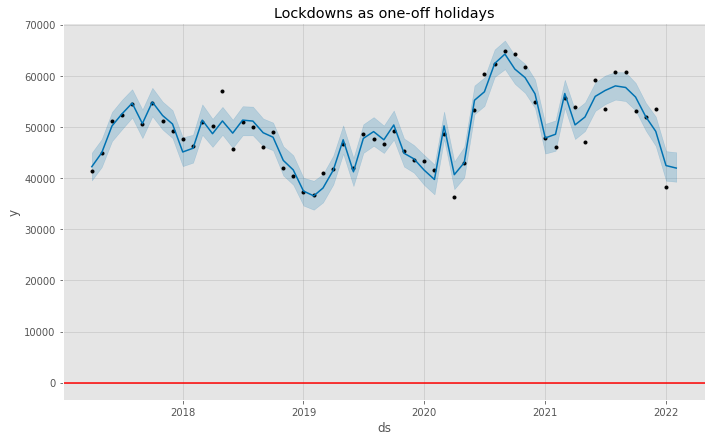

In [ ]:
import matplotlib.pyplot as plt
m.plot(forecast_only_gs)
# plt.plot(prop_df.ds,prop_df.y)
plt.axhline(y=0, color='red')
plt.title('Lockdowns as one-off holidays')

In [ ]:
lockdowns = pd.DataFrame([
    {'holiday': 'lockdown_1', 'ds': '2020-03-21', 'lower_window': 0, 'ds_upper': '2020-06-06'},
    {'holiday': 'lockdown_2', 'ds': '2020-07-09', 'lower_window': 0, 'ds_upper': '2020-10-27'},
    {'holiday': 'lockdown_3', 'ds': '2021-02-13', 'lower_window': 0, 'ds_upper': '2021-02-17'},
    {'holiday': 'lockdown_4', 'ds': '2021-05-28', 'lower_window': 0, 'ds_upper': '2021-06-10'},
])
for t_col in ['ds', 'ds_upper']:
    lockdowns[t_col] = pd.to_datetime(lockdowns[t_col])
lockdowns['upper_window'] = (lockdowns['ds_upper'] - lockdowns['ds']).dt.days

m2 = Prophet(**best_params,holidays=lockdowns)
m2 = m2.fit(prop_df)
future2 = m2.make_future_dataframe(periods=1,freq="MS")
forecast_gs_hols = m2.predict(future2)

02:35:48 - cmdstanpy - INFO - Chain [1] start processing
02:35:56 - cmdstanpy - INFO - Chain [1] done processing


In [ ]:
forecast_gs_hols[["ds","yhat","yhat_lower","yhat_upper",]].tail(6)

,ds,yhat,yhat_lower,yhat_upper
53,2021-09-01,55727.870723,53211.175674,58004.854638
54,2021-10-01,54197.948746,51525.628168,56530.767440
55,2021-11-01,52465.058648,49647.807567,54841.267214
56,2021-12-01,49461.797215,47049.763344,51854.518311
57,2022-01-01,42561.752142,39994.908264,45063.704129
58,2022-02-01,42158.560996,39756.733205,44609.143575


Text(0.5, 1.0, 'Lockdowns as one-off holidays')

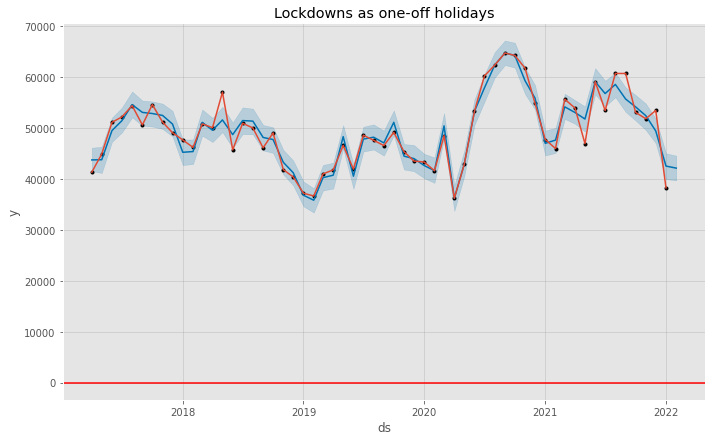

In [ ]:
import matplotlib.pyplot as plt
m2.plot(forecast_gs_hols)
plt.plot(prop_df.ds,prop_df.y)
plt.axhline(y=0, color='red')
plt.title('Lockdowns as one-off holidays')

In [ ]:
results_df = prop_df[["ds","y"]].copy()
results_df = pd.merge(results_df, raw_forecast[["ds","yhat"]], on=["ds"],how="left")
results_df = pd.merge(results_df, forecast_only_gs[["ds","yhat"]], on=["ds"],how="left")
results_df = pd.merge(results_df, forecast_gs_hols[["ds","yhat"]], on=["ds"],how="left")
results_df["ape"]
results_df.head()

,ds,y,yhat_x,yhat_y,yhat
0,2017-04-01,41359.841,42845.762243,42218.153984,43772.639576
1,2017-05-01,44928.990,45235.551908,44936.009649,43807.105770
2,2017-06-01,51147.202,49941.209048,50183.445116,49537.059598
3,2017-07-01,52226.264,51587.714536,52521.659079,51477.241620
4,2017-08-01,54431.449,53563.850344,54641.066969,54625.603213


In [ ]:
scoring_df = prop_df[["ds","y"]].copy()
scoring_df = scoring(scoring_df=scoring_df,predictions=raw_forecast.yhat_upper,model_name="raw_forecast", target_value="y")
scoring_df = scoring(scoring_df=scoring_df,predictions=forecast_only_gs.yhat_upper,model_name="forecast_only_gs", target_value="y")
scoring_df = scoring(scoring_df=scoring_df,predictions=forecast_gs_hols.yhat_upper,model_name="forecast_gs_hols", target_value="y")
scoring_df.head()

Number of records greater than 20 percent error: 19
Number of records greater than 15 percent error: 27
Number of records greater than 10 percent error: 30
Number of records greater than 5 percent error: 35
Number of records greater than 20 percent error: 21
Number of records greater than 15 percent error: 25
Number of records greater than 10 percent error: 30
Number of records greater than 5 percent error: 35
Number of records greater than 20 percent error: 20
Number of records greater than 15 percent error: 24
Number of records greater than 10 percent error: 29
Number of records greater than 5 percent error: 37


,ds,y,raw_forecast_prediction,raw_forecast_rmse,raw_forecast_absolute_percent_error,forecast_only_gs_prediction,forecast_only_gs_rmse,forecast_only_gs_absolute_percent_error,forecast_gs_hols_prediction,forecast_gs_hols_rmse,forecast_gs_hols_absolute_percent_error
15,2017-04-01,41359.841,56903.599198,10991.096827,37.581765,54037.020593,8964.119657,30.650939,54095.060862,9005.160324,30.791269
16,2017-05-01,44928.990,58535.894324,9621.534319,30.285355,53951.231459,6379.688117,20.081113,53833.986810,6296.783630,19.820158
17,2017-06-01,51147.202,57261.501643,4323.462740,11.954319,51630.524708,341.760764,0.944964,50627.375236,367.573030,1.016335
18,2017-07-01,52226.264,58870.559090,4698.226114,12.722134,50836.897351,982.430579,2.660283,50195.700191,1435.825439,3.888013
19,2017-08-01,54431.449,53968.886530,327.081060,0.849807,46184.388095,5831.552691,15.151279,45746.951898,6140.866792,15.954925


Shape of dataframe is :  (58, 11)


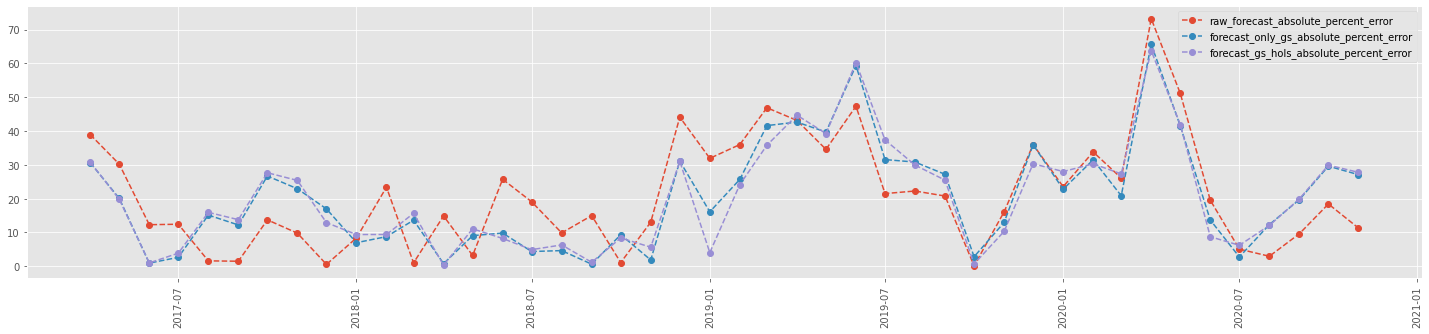

In [ ]:
from src.utils.plotting import plot_metrics
plot_metrics(scoring_df, col_x="ds", col_y1="raw_forecast_absolute_percent_error", col_y2="forecast_only_gs_absolute_percent_error", col_y3="forecast_gs_hols_absolute_percent_error")

In [ ]:
# prop_df -> y
# raw_forecast -> y
# forecast_only_gs -> y
# forecast_gs_hols -> y